<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-Isaias-Hernandez/blob/main/Nov3-4/proyecto_ml_mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Parcial - Implementación de inferencia bayesiana y cadenas de Markov

Por Isaías Hernández Lares

In [341]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

In [342]:
sns.set_palette("Paired")

______________________________________________
# Data set: Heart Failure Prediction Dataset
fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

"Las enfermedades cardiovasculares (ECV) son la principal causa de muerte a nivel mundial, cobrando aproximadamente 17.9 millones de vidas al año, lo que representa el 31% de todas las muertes en todo el mundo. Cuatro de cada 5 muertes por ECV se deben a ataques cardíacos y derrames cerebrales, y un tercio de estas muertes ocurren prematuramente en personas menores de 70 años. La insuficiencia cardíaca es un evento común causado por las ECV y este conjunto de datos contiene 11 características que se pueden utilizar para predecir una posible enfermedad cardíaca.

Las personas con enfermedades cardiovasculares o que tienen un alto riesgo cardiovascular (debido a la presencia de uno o más factores de riesgo como la hipertensión, la diabetes, la hiperlipidemia o una enfermedad ya establecida) necesitan detección temprana y manejo, en donde un modelo de aprendizaje automático puede ser de gran ayuda."

Attribute Information
* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
*HeartDisease: output class [1: heart disease, 0: Normal]

-----------------------------

Como objetivo se espera predecir a partir de los mediciones si el paciente cuenta con enfermedad cardiaca.


In [316]:
heart = pd.read_csv("/content/drive/MyDrive/ML2023/heart.csv")
numericos = ["Age",'RestingBP', 'Cholesterol', 'MaxHR', "Oldpeak"]
categorical = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]

In [317]:
heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


El Dataset cuenta con mediciones de valor 0 en columnas de "Cholesterol" y "Oldpeak". Para poder graficar sin que sean tomadas en cuenta y observar las relaciones que hay entre las variables las asignamos a nan.

In [318]:
heart.loc[heart.Oldpeak==0, "Oldpeak"] = np.nan
heart.loc[heart.Cholesterol==0, "Cholesterol"] = np.nan

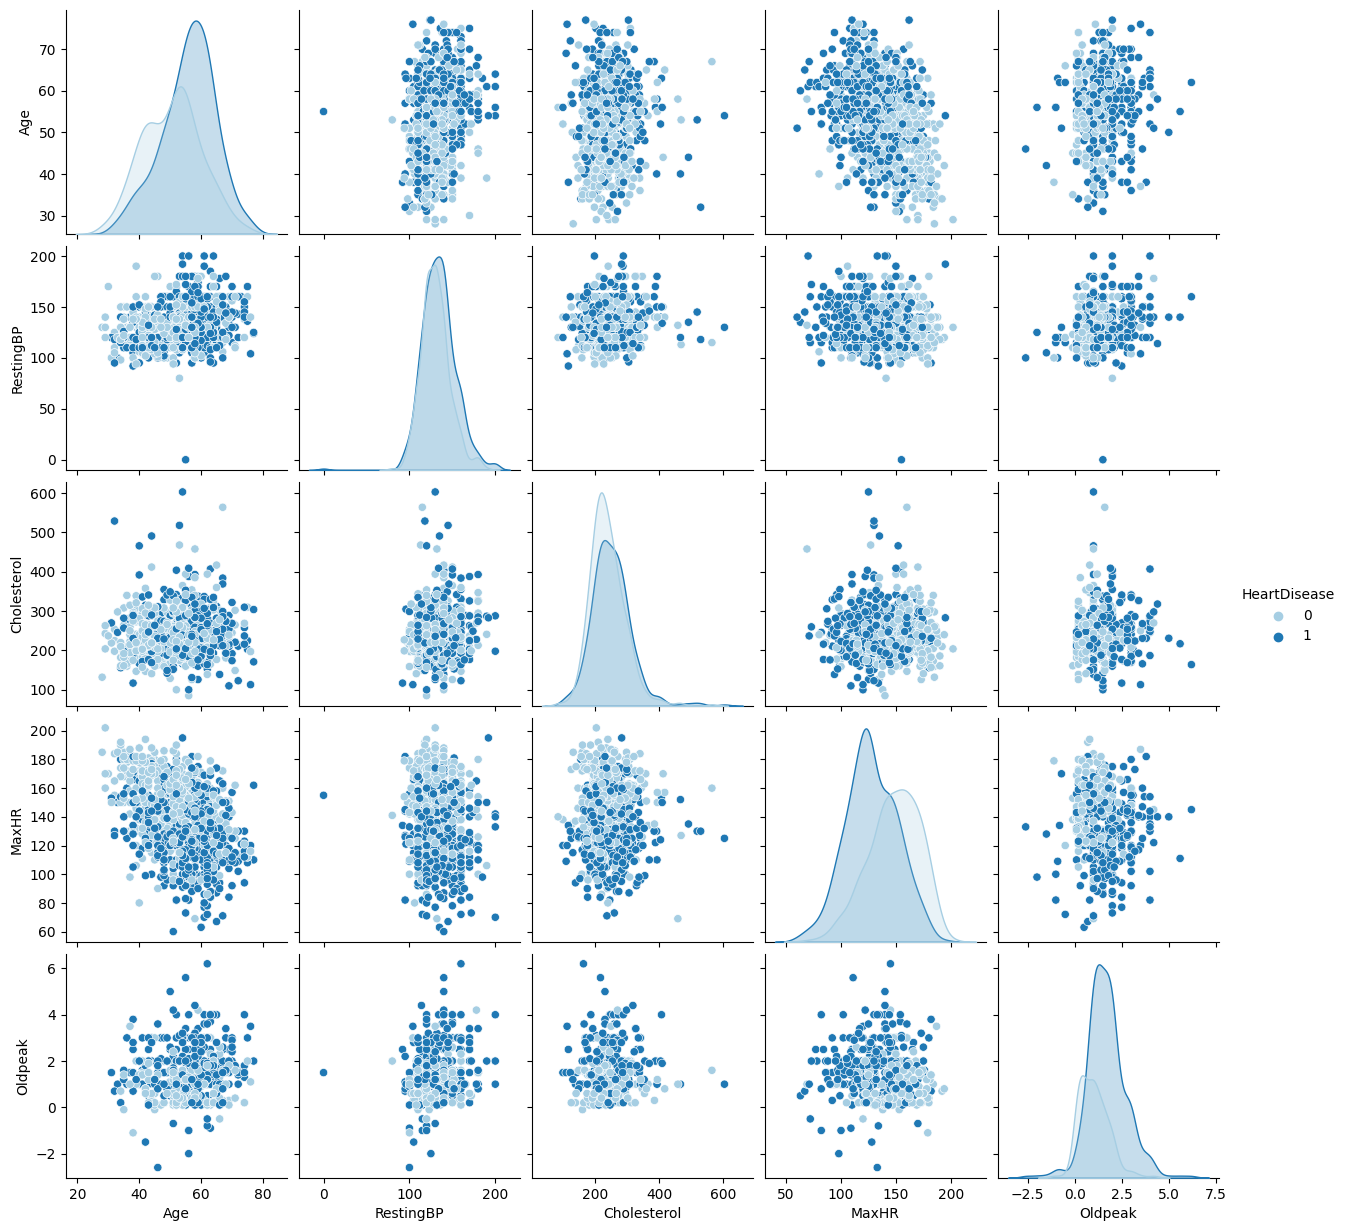

In [319]:
heart_1 = heart.drop("FastingBS", axis=1)
sns.pairplot(heart_1, hue="HeartDisease")

Graficamos las variables numéricas del dataset. En esta predicción unicamente se utilizan las variables numéricas para predecir le enfermedad cardiaca. Algunas variables categóricas son indudablemente relevantes para la predicción, pero no se implementaron porque no sabía cómo añadirlas al modelo.

Podemos observar las distribuciones con una gráfica "violin" de las variables categóricas. Para observarlas todas podemos variar el índice de la variable "categorical".

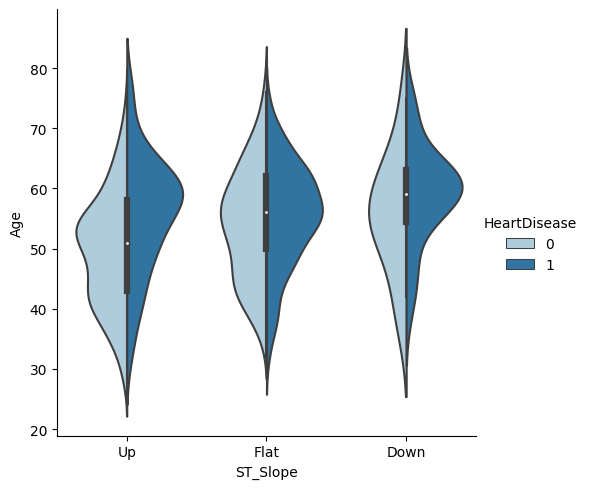

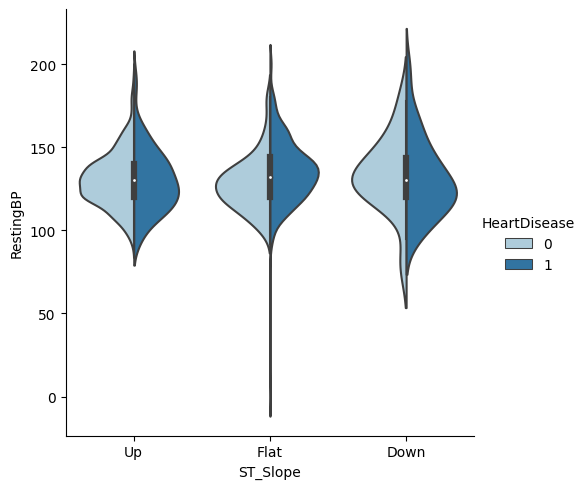

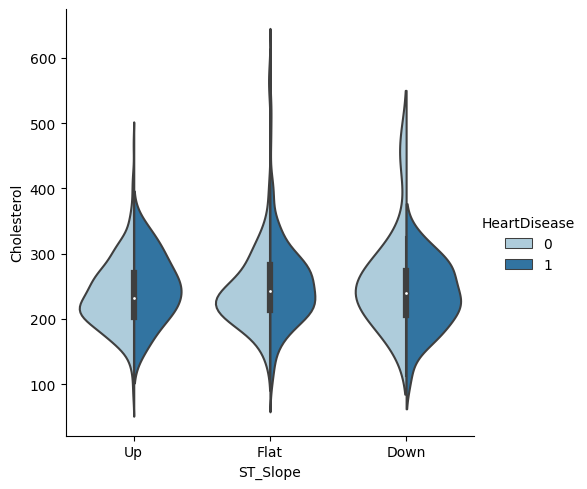

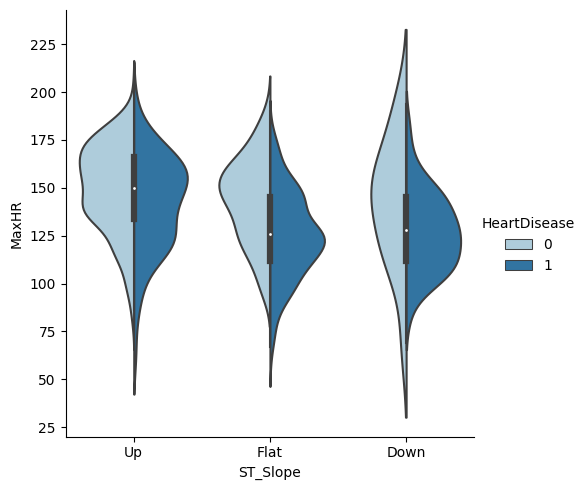

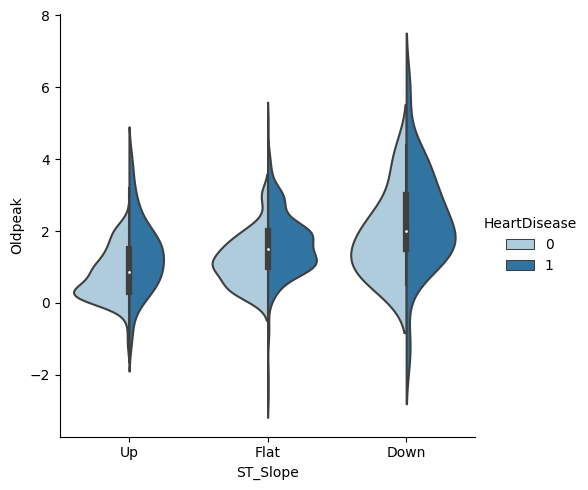

In [320]:
# categorical = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]
cat = categorical[5]
for col in numericos:
  sns.catplot(data=heart, x=cat, y=col, hue="HeartDisease", kind="violin", split=True)

--------------
# Método

Para el modelo observamos que la predicción dada por el dataset es un valor booleano, verdadero representado con el número 1 y falso, representado con el número 0. Por esta razón se busca que el modelo pueda replicar las dos salidas únicamente. Se emplea un modelo de regresión logística, un modelo que graficamente se ve como una curva sigmoide y tiene la siguiente forma:

$$
y = \frac{1}{1+ e^{-X\theta}}
$$

Donde $\theta$ son los parametros a ajustar y $X$ el conjunto de mediciones. En este caso, la exponencial tiene la forma:
$$
e^{-X\theta} = e^{-(\theta_1 + \theta_2*X_1 + \theta_3*X_2+ \theta_4*X_3 + \theta_5*X_4 + \theta_6*X_5)}
$$

In [343]:
def reg_logistica(x, w):
  e, w_1 = w[0], w[1:]
  #pdb.set_trace()
  for x_n, w_n in zip(x, w_1):
    e += x_n * w_n
  y = 1 / (1 + np.exp(-1*e))
  return y

Se emplea un likelihood gaussiano y prior plano

In [323]:
#Likelihood
def Log_Likelihood(x, y, w, modelo):
  likelihood = -0.5 * np.sum((y - modelo(x, w))**2)
  return likelihood

#Prior Plano
def Log_Prior(w, rangos):
  flag = True
  for min, max, w in zip(rangos[0], rangos[1], w):
    if not (min <= w <= max):
      flag = False
  if flag:
    return 0
  else:
    return -np.inf

#Posterior
#def Log_Posterior(x, y, w, modelo, minimos, maximos):
def Log_Posterior(x, y, w, modelo, rangos):
  logl = Log_Likelihood(x, y, w, modelo)
  #logp = Log_Prior(w, minimos, maximos)
  logp = Log_Prior(w, rangos)

  posterior = logl + logp
  return posterior

In [324]:
def generar_parametros(w, std):
  parametros = []
  for mu, sigma in zip(w, std):
    w_nuevo = np.random.normal(mu, sigma)
    parametros.append(w_nuevo)
  return np.array(parametros)

In [325]:
#def Metropoli(x, y, iteraciones, modelo, theta_i, theta_min, theta_max, std, Log_Likelihood, Log_Prior, Log_Posterior):
def Metropoli(x, y, iteraciones, modelo, w_inicial, rangos, std):
  #w_inicial = theta_i
  #w_incial = generar_parametros(w_inicial, std)
  reg_aceptadas, reg_rechazadas, reg_rechazadas_inf = [], [], []

  for i in range(iteraciones):
    #w_propuesta = [np.random.normal(theta_inicial[0], sigma_ordenada), np.random.normal(theta_inicial[1], sigma_pendiente)]

    w_propuesta = generar_parametros(w_inicial, std)

    #posterior_inicial = Log_Posterior(x, y, w_inicial, modelo, theta_min, theta_max)
    posterior_inicial = Log_Posterior(x, y, w_inicial, modelo, rangos)
    #posterior_propuesta = Log_Posterior(x, y, w_propuesta, modelo, theta_min, theta_max)
    posterior_propuesta = Log_Posterior(x, y, w_propuesta, modelo, rangos)

    if posterior_propuesta == -np.inf:
      reg_rechazadas_inf.append(w_propuesta)
      continue
    #pdb.set_trace()
    if posterior_propuesta > posterior_inicial:
      w_inicial = w_propuesta
      reg_aceptadas.append(w_propuesta)

    else:
      r = np.log(np.random.uniform())
      if (posterior_propuesta-posterior_inicial) > r:
        w_inicial = w_propuesta
        reg_aceptadas.append(w_propuesta)

      else:
        reg_rechazadas.append(w_propuesta)

  cociente_rechazados = np.shape(reg_rechazadas)[0]/iteraciones
  cociente_rechazados_inf = np.shape(reg_rechazadas_inf)[0]/iteraciones
  cociente_aceptacion = np.shape(reg_aceptadas)[0]/iteraciones
  cocientes = [cociente_aceptacion, cociente_rechazados, cociente_rechazados_inf]

  return np.array(reg_aceptadas), cocientes

In [326]:
heart = heart.fillna(0)
y = heart["HeartDisease"].values
x = heart[numericos].values.T

In [327]:
x_norm = x
for i in range(x.shape[0]):
  x_norm[i] = (x[i] - np.mean(x[i])) / np.std(x[i])
x_norm

array([[-1.4331398 , -0.47848359, -1.75135854, ...,  0.37009972,
         0.37009972, -1.64528563],
       [ 0.41090889,  1.49175234, -0.12951283, ..., -0.12951283,
        -0.12951283,  0.30282455],
       [ 0.82507026, -0.17196105,  0.7701878 , ..., -0.62016778,
         0.34027522, -0.21769643],
       [ 1.38292822,  0.75415714, -1.52513802, ..., -0.85706875,
         1.4615246 ,  1.42222641],
       [-0.83243239,  0.10566353, -0.83243239, ...,  0.29328271,
        -0.83243239, -0.83243239]])

Se definen las variables para utilizar el método monte carlo markov chain metropoli implementado en la función de anterior.

In [328]:
w = [1.4, 1.5, 0.4, -3, -2, 5.6]
w = np.array(w)
std = [0.001, .001, .001, .001, .001, .01]
std = np.array(std)
rangos = [[-5, -5, -5, -5, -5, -5], [5, 5, 5, 5, 5, 10]]
iteraciones = 10000

In [329]:
Log_Posterior(x,y, w, reg_logistica, rangos)

-90.84926767352225

In [330]:
resultados, cocientes = Metropoli(x_norm, y, iteraciones, reg_logistica, w, rangos, std)

In [331]:
cocientes

[0.9951, 0.0049, 0.0]

In [332]:
#Falta el burning (eliminar los datos que no están en la distribución que se ocupa)
print(resultados.shape)
n=-int(iteraciones*0.5)
resultados = resultados[n:]
print(resultados.shape)

(9951, 6)
(5000, 6)


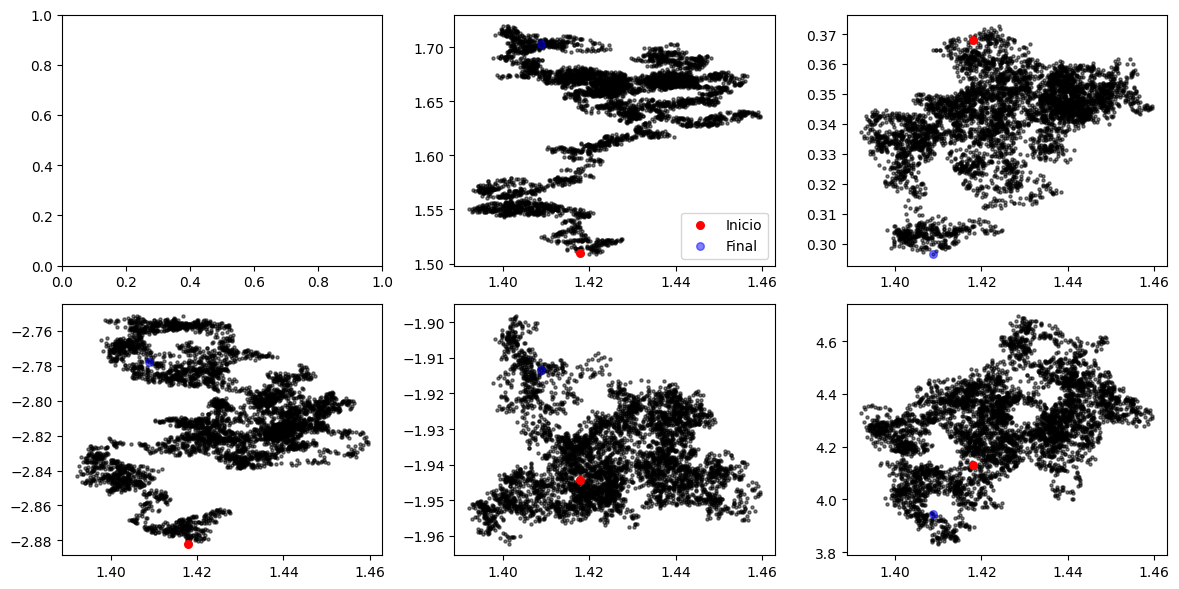

In [333]:
n = resultados.shape[1]
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
i=0
for f, g, h in zip(range(n), [0, 0, 0, 1, 1, 1], [0,1,2,0,1,2]):
  if f != i:
    ax[g, h].scatter(resultados[:, i], resultados[:,f], 5, alpha=0.5, color="black")
    ax[g, h].scatter(resultados[:, i][0], resultados[:, f][0], 30, "red", alpha=1, label="Inicio")
    ax[g, h].scatter(resultados[:, i][-1], resultados[:, f][-1], 30, "blue", alpha=.5, label="Final")

ax[0, 1].legend()
plt.tight_layout()
plt.show()

In [334]:
prediccion = []

for i in range(n):
  counts, bins = np.histogram(resultados[:, i], bins=20)
  mean_value = np.sum(bins[:-1] * counts) / np.sum(counts)
  prediccion.append(mean_value)

print("Predicción:", prediccion)
prediccion = np.array(prediccion)

Predicción: [1.4226239769222506, 1.6370439124094045, 0.3389476343620179, -2.8121106134588216, -1.9385966201659817, 4.254148889003239]


Predicción: [1.389, 1.457, 0.392, -3.002, -2.020, 5.699]

Predicción: [1.325, 1.451, 0.354, -3.108, -2.106, 5.225]

Predicción: [1.402, 1.372, 0.342, -3.131, -2.000, 5.945]

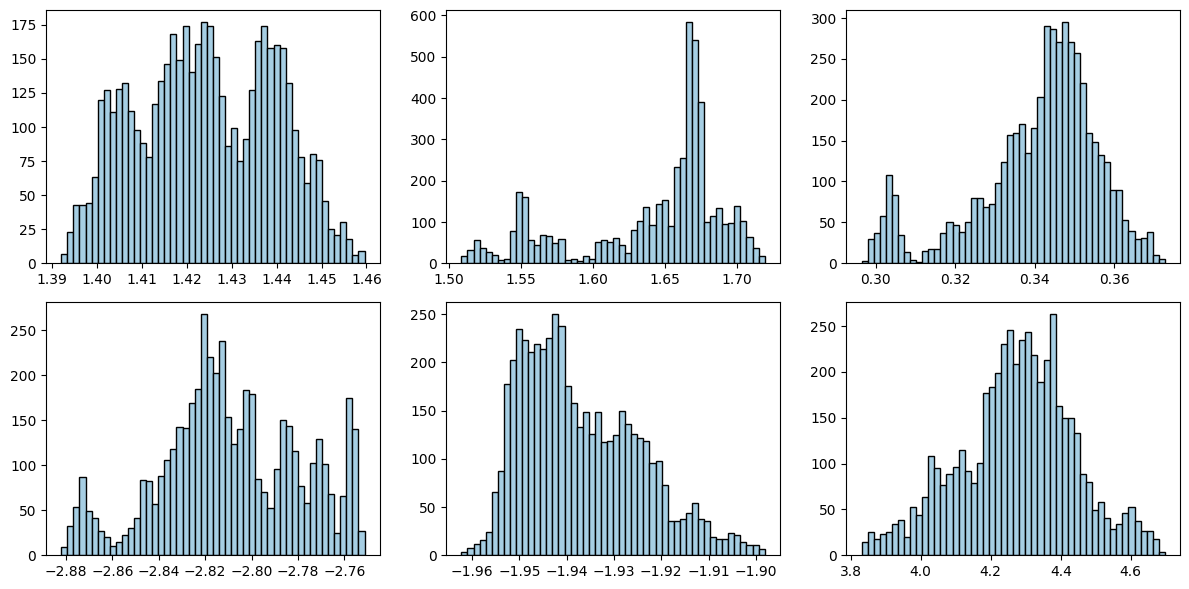

In [335]:
n = resultados.shape[1]
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
for i, g, h in zip(range(n), [0, 0, 0, 1, 1, 1], [0,1,2,0,1,2]):
  ax[g, h].hist(resultados[:,i], bins=50, edgecolor='black')

plt.tight_layout()
plt.show()

In [336]:
y_prediccion = reg_logistica(x, prediccion)
y_prediccion = np.round(y_prediccion)

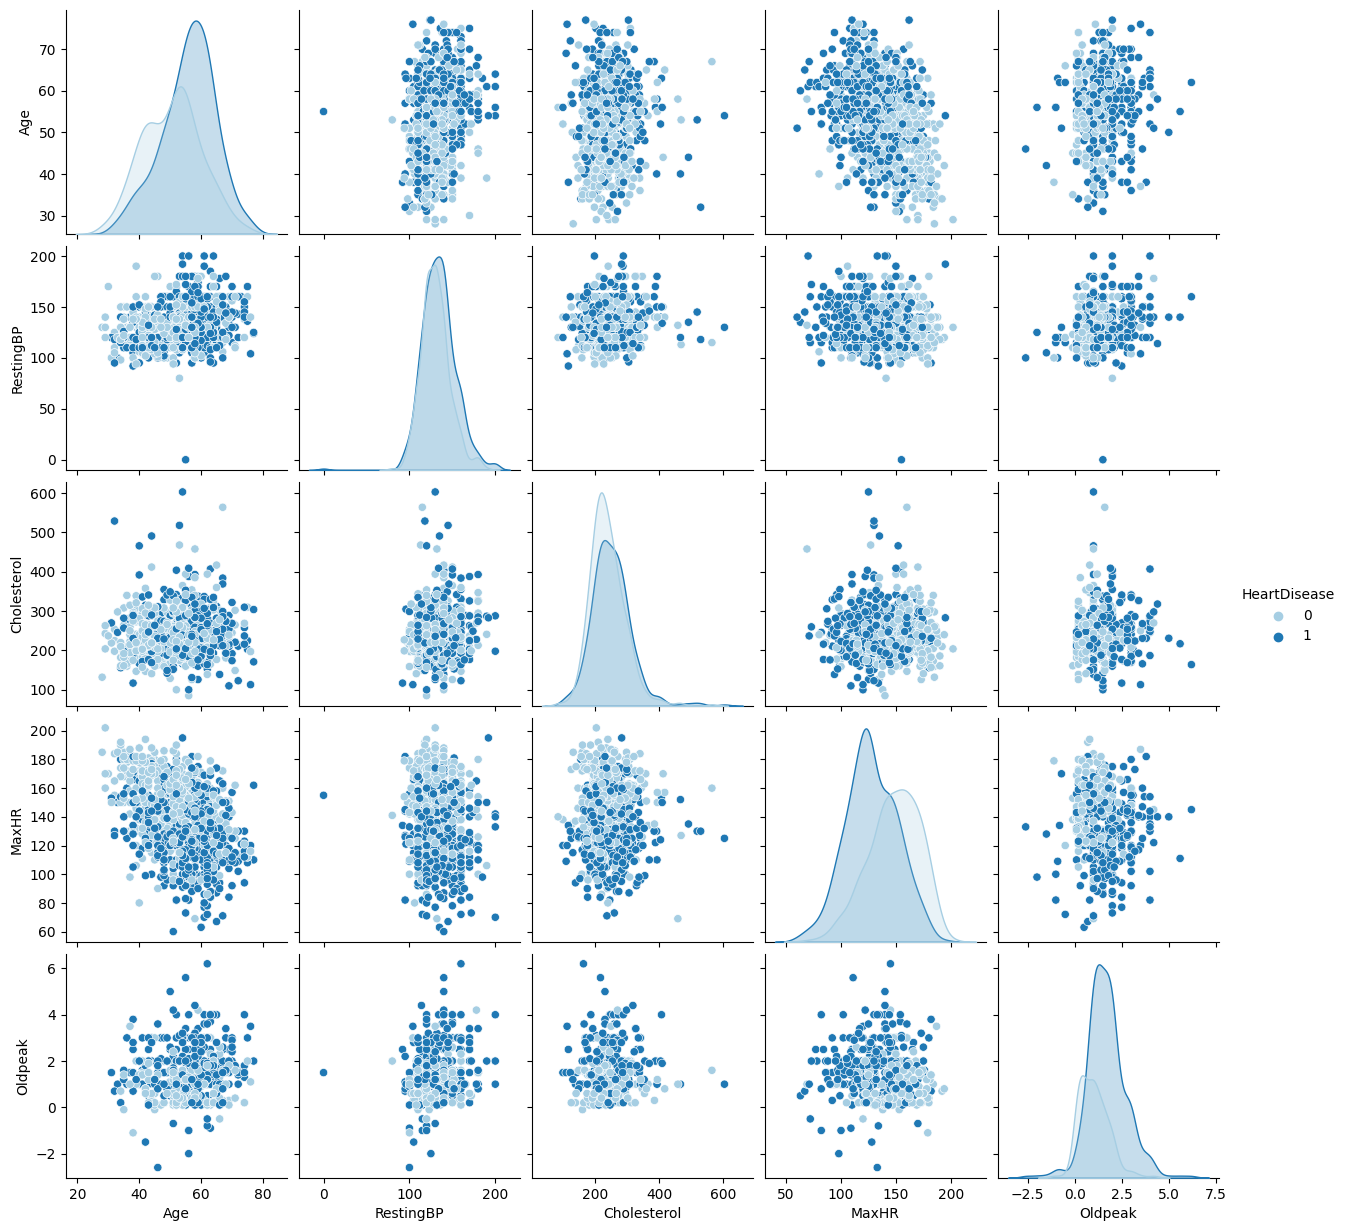

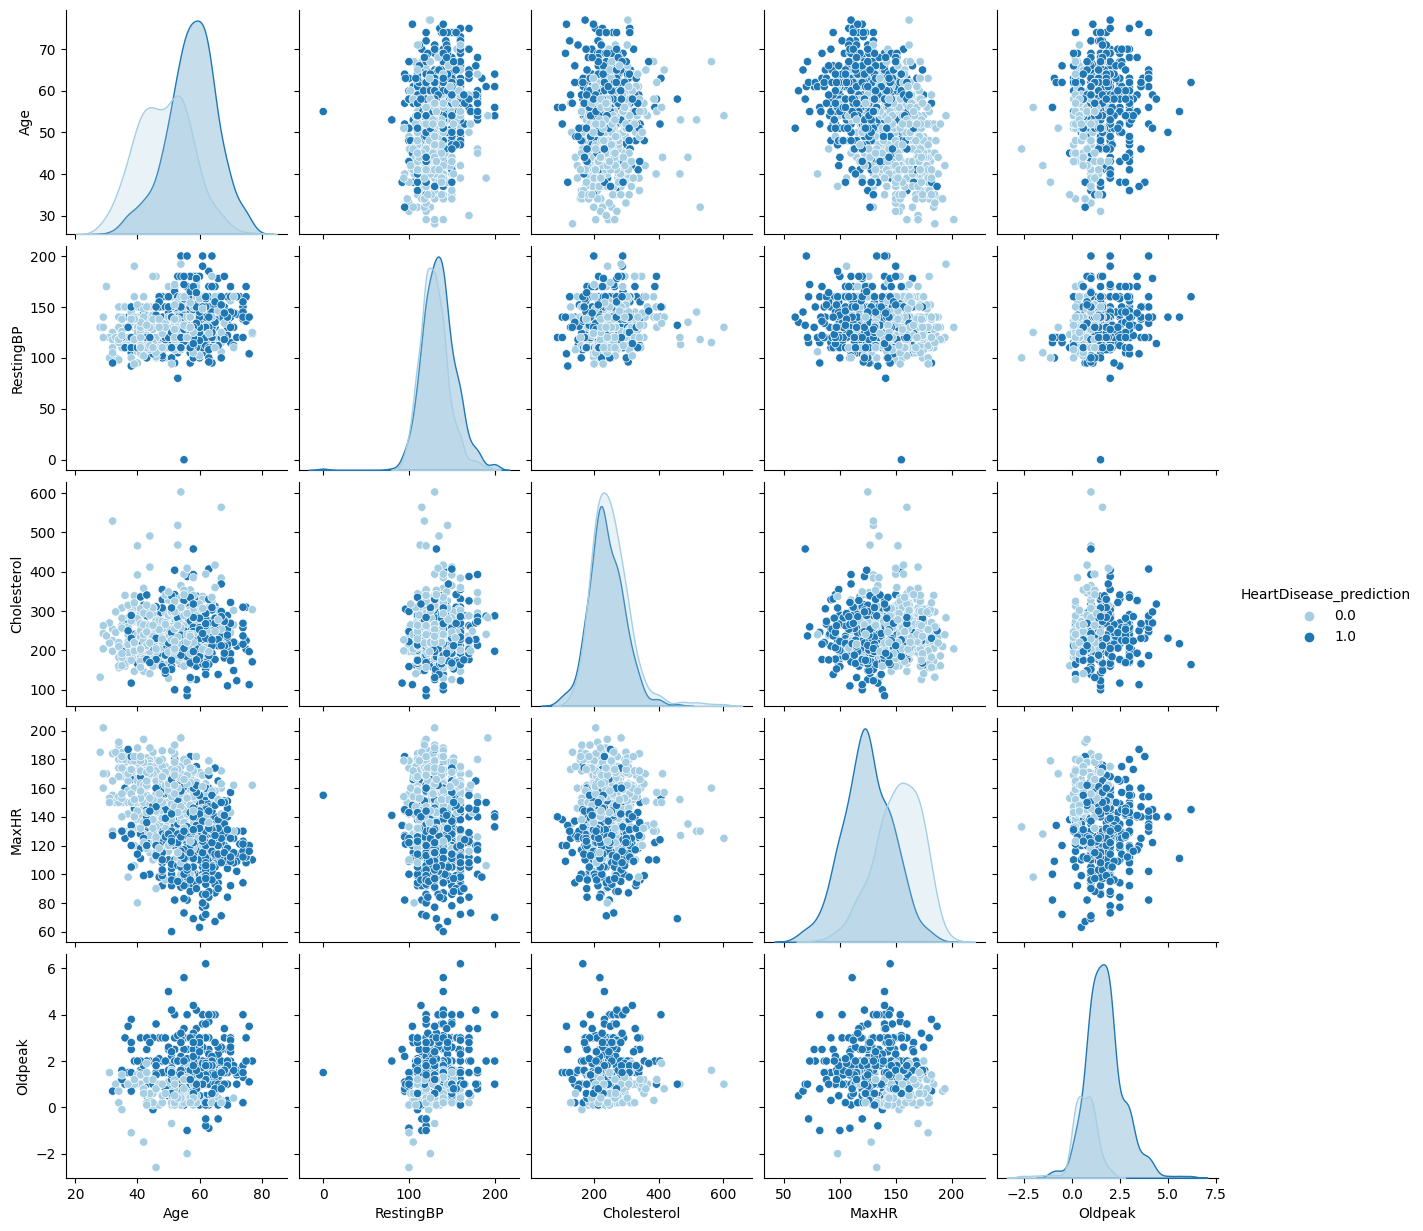

In [340]:
sns.pairplot(heart_1, hue="HeartDisease")
heart_2 = heart_1.drop("HeartDisease", axis=1)
heart_2["HeartDisease_prediction"] = y_prediccion
sns.pairplot(heart_2, hue="HeartDisease_prediction")

------------------------------
# Convergencia

In [338]:
def cadenas(no_cadenas, burning, x, y, iteraciones, modelo, rangos, std):
  m = no_cadenas
  n = burning
  ws = []
  for i in range(std.shape[0]):
    w_i = np.random.uniform(rangos[0][i], rangos[1][i])
    ws.append(w_i)
  ws =np.array(ws)

  cadenas = []
  for i in range(m):
    w = generar_parametros(ws, std)
    cad, _ = Metropoli(x, y, iteraciones, modelo, w, rangos, std)
    cad = cad[-n:]
    cadenas.append(cad)
  cadenas = np.array(cadenas)
  return cadenas

def gelman_rubin(m, n, cadenas):
  Xi = np.zeros((m, cadenas.shape[-1]))
  for i in range(m):
    for j in range(cadenas.shape[-1]):
      promedios = 1/n * np.sum(cadenas[i, :, j])
      Xi[i, j] = promedios


  si = np.zeros((m, cadenas.shape[-1]))
  for i in range(m):
    for j in range(cadenas.shape[-1]):
      varianza = 1/(n-1) * np.sum((cadenas[i, :, j] - Xi[i, j])**2)
      si[i, j] = varianza
  np.sqrt(si)

  W = np.zeros((cadenas.shape[-1]))
  for i in range(cadenas.shape[-1]):
    mean = 1/m * np.sum(si[:,i])
    W[i] = mean

  mu = np.zeros((cadenas.shape[-1]))
  for i in range(cadenas.shape[-1]):
    mean = 1/m * np.sum(Xi[:,i])
    mu[i] = mean

  Bn = np.zeros((cadenas.shape[-1]))
  for i in range((cadenas.shape[-1])):
    bn = 1/(m-1) * np.sum((Xi[:,i]-mu[i])**2)
    Bn[i] = bn

  sigma = np.zeros((cadenas.shape[-1]))
  sigma = (n-1)/n * W + Bn

  R = np.sqrt(sigma/W)
  return R

def convergencia(no_cadenas, burning, x, y, iteraciones, modelo, rangos, std):
  cad = cadenas(no_cadenas, burning, x, y, iteraciones, modelo, rangos, std)
  R = gelman_rubin(no_cadenas, burning, cad)
  print("R: ", R)
  return R

In [339]:
cad = convergencia(5, 5000, x_norm, y, iteraciones, reg_logistica, rangos, std)

R:  [3.03982525 3.504939   1.83275203 2.95372432 3.8786145  1.38717109]
